# Q-learning using CartPole example

In [1]:
import numpy as np
import torch, random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import HTML
from cartpole_utils import env_cartpole, display_frames_as_gif, goalAchieved, test_cartpole

# Game

### Illustration of random moves

In [5]:
frames = test_cartpole(env_cartpole, 300)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

/home/niuniu/Documents/RL/env_rl/lib64/python3.13/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


43


# Q-table

Use discretisization to construct a Q-table of size NxM where N is the number of states and M is the number of actions.
Refer to Room Example for more details.

In [10]:
def codeState(state):
    position, velocity, angle, rate = state
    position_bins = np.linspace(-2.0, 2.0, 9)
    angle_bins = np.linspace(-0.5, 0.5, 9)
    velocity_bins = np.linspace(-1, 1, 9)
    rate_bins = np.linspace(-3.5, 3.5, 9)
    state = np.array([np.digitize(x =[position], bins=position_bins)[0],
            np.digitize(x =[angle], bins=angle_bins)[0],
            np.digitize(x =[velocity], bins=velocity_bins)[0],
            np.digitize(x =[rate], bins=rate_bins)[0],])
    return int("".join(map(lambda x: str(int(x)), state)))

In [7]:
state_num = 10**4 # 
action_num = 2
nb_episode = 1000 # number of episodes which is the game rounds
gamma = 0.8 #decay factor of Q-value
alpha = 0.7 #learning rate
epsilon = 1.0 #exploration rate

Q = np.zeros([state_num, action_num]) # initialize Q-table
scores = []

for e in range(nb_episode):
    state, _ = env_cartpole.reset()
    currState = codeState(state)
    continue_game = True
    score = 0
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action = env_cartpole.action_space.sample()
        else:
            action = np.argmax(Q[currState])

        state, reward, done, info, _ = env_cartpole.step(action)
        nextState =codeState(state)

        if done:
            reward = -100
            epsilon = epsilon * 0.995

        Q[currState,action] = (1 - alpha) * Q[currState, action] + alpha * (reward + gamma*np.max(Q[nextState,:]))

        currState = nextState
        score += 1

    scores = np.append(scores, score)

    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, epsilon: {epsilon}")
    if goalAchieved(scores):
        break


epoche:  0  score:  10 epsilon:  0.995
epoche:  100  score:  26 epsilon:  0.6027415843082742
epoche:  200  score:  59 epsilon:  0.36512303261753626
epoche:  300  score:  244 epsilon:  0.2211807388415433
epoche:  400  score:  104 epsilon:  0.13398475271138335
epoche:  500  score:  53 epsilon:  0.0811640021330769
epoche:  600  score:  203 epsilon:  0.04916675299948831
epoche:  700  score:  75 epsilon:  0.029783765425331846
epoche:  800  score:  205 epsilon:  0.018042124582040707


In [34]:
frames = test_cartpole(env_cartpole, 300, policy=Q, codage=codeState)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

301


# DQL

It can be seen from the previous example that the Q table is not practical for large state space and continuous space values. So one intuition wil be replacing the Q table by a neural network, which can handle contious Q values easily.
In practice, we need a network with the state space as input (in this case 4 float values) and the action space as outputs (in this case 2 Q values associated to the actions).

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Qnet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 728)
        self.fc2 = nn.Linear(728, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, state):
        out = torch.relu(self.fc1(state))
        out = torch.relu(self.fc2(out))
        return self.fc3(out)

In [137]:
state_num = 4 # 
action_num = 2
nb_episode = 3000 # number of episodes which is the game rounds
gamma = 0.8 #decay factor of Q-value
alpha = 0.9 #learning rate
epsilon = 1.0 #exploration rate
epsilon_decay = epsilon / 3000
epsilon_final = 0.1

qnet = Qnet(state_num, action_num) # initialize Q-table
optimizer = torch.optim.SGD(qnet.parameters(), lr=0.001)
scores = []

for e in range(nb_episode):
    state, _ = env.reset()
    state = torch.Tensor(state)
    currState = state
    continue_game = True
    score = 0
    done = False
    avg_loss = 0
    count = 0

    while not done:
        ## at each state, we take an action balancing the exploration and exploitation.
        # here we decrease the exploration with the advancement of learning.
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(qnet(currState)).detach().item()

        ## step forward the game to get the next state to update the Q values
        state, reward, done, info, _ = env.step(action)
        state = torch.Tensor(state)
        nextState = state.detach().clone()

        ## at the end of episode, we update the epsilon value
        if done:
            reward = -1
            if epsilon - epsilon_decay >= epsilon_final:
                epsilon -= epsilon_decay

        ## compute the Q value of the current state, used to update the network
        q_value = qnet(currState)

        ## compute the q value of the next state, used as the target value of the network
        q_target = q_value.detach().clone()
        # if we do not detach the target from the graph the convergence is slower
        q_next = torch.max(qnet(nextState)).detach()

        q_target[action] = reward + gamma * q_next

        currState = nextState

        ## update network
        loss = F.mse_loss(q_value, q_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ## update metrics
        score += 1
        avg_loss += loss.item()
        count += 1
    
    scores = np.append(scores, score)

    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, loss: {avg_loss/count:.6f}, epsilon: {epsilon:.6f}")
    if goalAchieved(scores):
        break

epoche: 100, score: 17, loss: 0.117991, epsilon: 0.966667
epoche: 200, score: 37, loss: 0.049101, epsilon: 0.933333
epoche: 300, score: 13, loss: 0.144942, epsilon: 0.900000
epoche: 400, score: 39, loss: 0.051824, epsilon: 0.866667
epoche: 500, score: 12, loss: 0.145761, epsilon: 0.833333
epoche: 600, score: 29, loss: 0.065049, epsilon: 0.800000
epoche: 700, score: 17, loss: 0.109379, epsilon: 0.766667
epoche: 800, score: 25, loss: 0.064469, epsilon: 0.733333
epoche: 900, score: 74, loss: 0.028874, epsilon: 0.700000
epoche: 1000, score: 95, loss: 0.021653, epsilon: 0.666667
epoche: 1100, score: 52, loss: 0.038000, epsilon: 0.633333
epoche: 1200, score: 118, loss: 0.011846, epsilon: 0.600000
epoche: 1300, score: 84, loss: 0.018752, epsilon: 0.566667
epoche: 1400, score: 223, loss: 0.009220, epsilon: 0.533333
epoche: 1500, score: 103, loss: 0.020230, epsilon: 0.500000


In [24]:
frames = test_cartpole(env_cartpole, 300, policy=qnet)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

301


# Replay

The previous setup consums the data in sequence, which is not good for network for training. So we refactor the code to train the network with random selected data in batches.

In [155]:
class ReplayMemory:
    def __init__(self, size):
        self.size = size
        self.games = []

    def add(self, curState, reward, action, nextState, done):
        if len(self)  > self.size:
            self.games.pop(0)
        reward = -1.0 if done else reward
        self.games.append([curState, reward, action, nextState, done])
        

    def __len__(self):
        return len(self.games)
    
    def sample(self, batch_size):
        if len(self) >= batch_size:
            samples = random.sample(self.games, batch_size)
            
            curState = torch.tensor([s[0] for s in samples])
            reward = torch.tensor([s[1] for s in samples]).unsqueeze(1)
            action = torch.tensor([s[2] for s in samples]).unsqueeze(1)
            nextState = torch.tensor([s[3] for s in samples])
            done = torch.tensor([s[4] for s in samples]).unsqueeze(1)
            return curState, reward, action, nextState, done
        else:
            print("Not enough samples yet.")
        return None
    
# tests
rm = ReplayMemory(10)
for i in range(10):
    rm.add([1,2],8,3,4,5)

s, reward, action, nextS, done = rm.sample(5)
reward.shape

torch.Size([5, 1])

In [194]:
class DQLAgent:
    def __init__(self, env, net, batch_size=128, epsilon=1.0, epsilon_decay=1.0/3000, epsilon_min=0.1):
        self.model = net
        self.env = env
        self.epsilon = epsilon #exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_final = epsilon_min
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)
        self.batch_size = batch_size

    def act(self, state, train=True):
        if np.random.random() < self.epsilon and train:
            action = self.env.action_space.sample()
        else:
            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                action = torch.argmax(self.model(state)).detach().item()
        return action
    
    def update_epsilon(self):
        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_final:
            self.epsilon = self.epsilon_final
    
    def learn(self, plays, alpha=0.9, gamma=0.8):
        samples = plays.sample(self.batch_size)
        
        # get samples batch
        state, reward, action, nextState, done = samples

        # compute the q values
        q_values = self.model(state)

        # we copy the q values, then adapt them after
        q_targets = q_values.detach().clone()

        with torch.no_grad():
            test = self.model(nextState).detach()
        q_nexts = torch.max(test, 1)[0].unsqueeze(1)

        # tmp = (1 - alpha) * torch.gather(q_targets, dim=1, index=action) + alpha * (reward + gamma * q_nexts)
        tmp = reward + gamma * q_nexts
        q_targets = q_targets.scatter(1, action, tmp)
        # print("Qingyi: ", q_values, q_targets)
        
        # update network
        loss = F.mse_loss(q_values, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.detach().item()
        

In [195]:
# train loop

epochs = 2000
state_num = 4 # 
action_num = 2
memory = ReplayMemory(1000)
model = Qnet(state_num, action_num)
agent = DQLAgent(env_cartpole, model, batch_size=4)

scores = []
losses = []

for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_loss = 0
    count = 0

    # run an episode
    while not done:
        
        # choose action
        action = agent.act(state)

        # take action on env
        state, reward, done, info, _ = env_cartpole.step(action)
        
        # add to replay memory
        memory.add(currState, reward, action, state, done)

        if len(memory) >= agent.batch_size:
            # train the network
            loss = agent.learn(memory)
            tot_loss += loss
            count += 1
            if not loss < 1e3:
                print(loss, count)

        currState = state.copy()
        # update score
        score += 1
    
    scores = np.append(scores, score)
    tmp = tot_loss/count if count > 0 else 0
    losses = np.append(losses, tmp)

    # update epsilon
    agent.update_epsilon()

    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, loss: {tot_loss/count:.6f}, epsilon: {agent.epsilon:.6f}")
    if goalAchieved(scores):
        break

epoche: 100, score: 8, loss: 0.106047, epsilon: 0.966667
epoche: 200, score: 46, loss: 0.083826, epsilon: 0.933333
epoche: 300, score: 17, loss: 0.033540, epsilon: 0.900000
epoche: 400, score: 24, loss: 0.124925, epsilon: 0.866667
epoche: 500, score: 19, loss: 0.025731, epsilon: 0.833333
epoche: 600, score: 25, loss: 0.081515, epsilon: 0.800000
epoche: 700, score: 17, loss: 0.052394, epsilon: 0.766667
epoche: 800, score: 15, loss: 0.059496, epsilon: 0.733333
epoche: 900, score: 16, loss: 0.027416, epsilon: 0.700000
epoche: 1000, score: 88, loss: 0.033963, epsilon: 0.666667
epoche: 1100, score: 52, loss: 0.026563, epsilon: 0.633333
epoche: 1200, score: 172, loss: 0.022485, epsilon: 0.600000
epoche: 1300, score: 42, loss: 0.020383, epsilon: 0.566667
epoche: 1400, score: 110, loss: 0.010584, epsilon: 0.533333
epoche: 1500, score: 203, loss: 0.016646, epsilon: 0.500000
epoche: 1600, score: 55, loss: 0.003363, epsilon: 0.466667


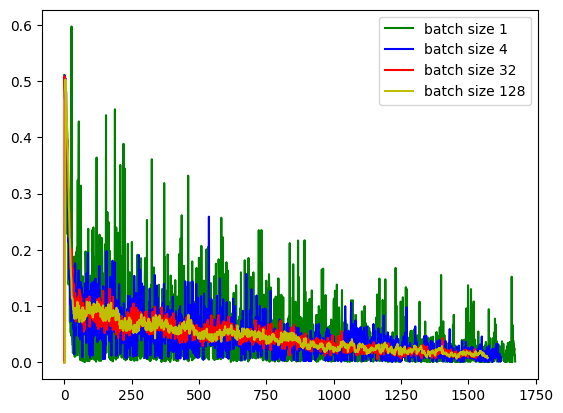

In [ ]:
# The greater batch size has a smoothing effect on the convergence.
# It can also be seen that the pole is more stable with higher batch size.

l128 = losses
plt.plot(l1, "g", label="batch size 1")
plt.plot(l4, "b", label="batch size 4")
plt.plot(l32, "r", label="batch size 32")
plt.plot(l128, "y", label="batch size 128")
plt.legend()

In [191]:
frames = test_cartpole(env_cartpole, 300, policy=model)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

301


# docs
resource:

 * DQN: https://keon.io/deep-q-learning/
 * qtable: https://gist.github.com/carlos-aguayo/3df32b1f5f39353afa58fbc29f9227a2
    
game instructions:
 * https://github.com/openai/gym/wiki/CartPole-v0
 * https://gym.openai.com/docs